# M3 - Lab 2 - Bag of words classification, Cross-validation &amp; Spatial Pyramids

#### Team 4: Laia Albors, Ibrar Malik, Daniel Rodriguez

In [3]:
import time
import cv2
import numpy as np
import pandas as pd
import pickle
from itertools import product
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

Let us first read the train and test files, and load the data into arrays.

In [4]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

train_images = []
for filename in train_images_filenames:
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    train_images.append(ima)
train_images = np.stack(train_images)

test_images = []
for filename in test_images_filenames:
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    test_images.append(ima)
test_images = np.stack(test_images)

print(f"Train images: {train_images.shape}\n Test images: {test_images.shape}")

Train images: (1881, 256, 256, 3)
 Test images: (807, 256, 256, 3)


We will write some util functions for later:

In [5]:
# Util functions
def generate_pyramid(shape, depth):
    y_min, y_max, x_min, x_max = shape

    top_left = [(y_max+y_min)//2, y_max, x_min, (x_max+x_min)//2]
    top_right = [(y_max+y_min)//2, y_max, (x_max+x_min)//2, x_max]
    bottom_left = [y_min, (y_max+y_min)//2, x_min, (x_max+x_min)//2]
    bottom_right = [y_min, (y_max+y_min)//2, (x_max+x_min)//2, x_max]
    splits = [top_left, top_right, bottom_left, bottom_right]
    
    all_splits = splits.copy()
    if depth - 1 > 0:
        for split in splits:
            all_splits += generate_pyramid(split, depth-1)
    
    return all_splits
    
generate_pyramid([0,255,0,255], 1)

[[127, 255, 0, 127],
 [127, 255, 127, 255],
 [0, 127, 0, 127],
 [0, 127, 127, 255]]

In [16]:
# TABLE:

def table_results(results):
    num_params = len(results['params'][0])
    name_params = [s.split('__')[1] if len(s.split('__'))>1 else s for s in results['params'][0]]
    complete_name_params = [s for s in results['params'][0]]
    dic = dict()
    for i,name in enumerate(name_params):
        dic[name] = results['param_'+complete_name_params[i]].data
    dic['train_acc'] = 100*results['mean_train_score']
    dic['val_acc'] = 100*results['mean_test_score']
    dic['mean_fit_time'] = results['mean_fit_time']
    dic['mean_score_time'] = results['mean_score_time']
    dic['mean_time'] = dic['mean_fit_time'] + dic['mean_score_time']
    return pd.DataFrame.from_dict(dic)

In [23]:
# PLOTS:

import matplotlib.pyplot as plt

def plot_results(results):
    df = table_results(results)
    num_params = len(df.columns)
    name_params = [df.columns[i] for i in range(num_params-5)]
    title = '-'.join(name_params) + " vs Accuracy and Execution Time"
    x_labels = ['-'.join([str(e) for e in row[1]]) for row in df[name_params].iterrows()]

    fig,ax1 = plt.subplots(1,1)
    colors = plt.cm.BuPu(np.linspace(0.25, 0.4, 2))
    plt.bar(np.arange(len(df)), df.train_acc, 0.35, color=colors[0])
    plt.bar(np.arange(len(df))+0.35, df.val_acc, 0.35, color=colors[1])
    ax1.legend(['Train', 'Validation'],loc=2)
    ax1.set_xticks(np.arange(len(df)))
    ax1.set_xticklabels(x_labels)
    ax1.tick_params(axis='x', rotation=90)

    ax1.set_xlabel(' - '.join(name_params))
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(top=100)  # adjust the top leaving bottom unchanged
    ax1.set_ylim(bottom=0)  

    ax2 = plt.twinx()
    ax2.plot(np.arange(len(df)), df.mean_time, 'g-o', linewidth=5, alpha=0.3)
    ax2.legend( ['Mean execution time'],loc=1)
    ax2.set_ylabel('Execution Time (s)')
    ax2.set_ylim(bottom=0)
    #ax2.set_ylim(top=320)  
    plt.title(title)
    plt.show()

def drawKeyPts(im,keyp,col,th,show=False):
    """Function to draw keyoints over an image."""
    for curKey in keyp:
        x=np.int(curKey.pt[0])
        y=np.int(curKey.pt[1])
        size = np.int(curKey.size)
        cv2.circle(im,(x,y),size//2, col,thickness=th, lineType=-1, shift=0)
    if show:
        plt.figure(figsize=(8,8))
        plt.imshow(im)    
    return im 

In the last deliverable we factorized everything into functions. This time we will join these functions into _sklearn_ Estimators. With these, we will be able to build Pipelines, and cross validate everything easily using _sklearn_ utilities such as `GridSearchCV`.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin


class BagOfVisualWords(TransformerMixin, BaseEstimator):
    """Given a set of images, transform them to visual words"""
    def __init__(self, 
                 codebook_size: int, 
                 dense_sift: bool = False, 
                 pyramid_depth: int = 0, 
                 step_size: int = 10, 
                 scales: list = [10],
                 norm: str = None):
        self.codebook_size = codebook_size
        self.dense_sift = dense_sift
        self.pyramid_depth = pyramid_depth
        self.step_size = step_size
        self.scales = scales
        self.norm = norm

    def generate_descriptors(self, images):
        detector = cv2.SIFT_create()
        if self.dense_sift:
            step_size = self.step_size
            scales = self.scales
            keypoints = [sum([[cv2.KeyPoint(x, y, scale) for y in range(0, image.shape[0], step_size) 
                                                         for x in range(0, image.shape[1], step_size)]
                                for scale in scales], [])
                          for image in images]

        descriptors = []
        positions = []
        for idx, image in enumerate(images):
            if self.dense_sift:
                kpt, des = detector.compute(image, keypoints[idx])
            else:
                kpt, des = detector.detectAndCompute(image,None)
            if des is None:
                # if the keypoint detector does not return any keypoint/descriptor
                # we will just use the avg. descriptor of all images until now.
                # it shouldn't have a big effect on classification.
                des = np.vstack(descriptors).mean(axis=0).reshape(1, -1)
            descriptors.append(des)
            positions.append([keypoint.pt for keypoint in kpt])
        descriptors = [np.array(desc) for desc in descriptors]
        
        # Normalize descriptors
        if self.norm is not None:
            descriptors = [normalize(desc, norm=self.norm) for desc in descriptors]
        
        return descriptors, positions

    def fit(self, X, y=None):
        # Generate descriptor features to fit the codebook
        descriptors, _ = self.generate_descriptors(X)
        D = np.vstack(descriptors)
        codebook = MiniBatchKMeans(n_clusters=self.codebook_size, verbose=False,
                                   batch_size=self.codebook_size * 20,
                                   compute_labels=False,reassignment_ratio=10**-4,
                                   random_state=42)
        codebook.fit(D)
        self.codebook = codebook

        return self

    def transform(self, X):

        descriptors, positions = self.generate_descriptors(X)
        n = len(descriptors)
        k = self.codebook_size
        visual_words=np.zeros((n, sum([k*(4**i) for i in range(self.pyramid_depth+1)])), dtype=np.float32)
        for i in range(n):
            words = self.codebook.predict(descriptors[i])
            visual_words[i,:k] = np.bincount(words,minlength=k)

        if self.pyramid_depth > 0:
            h, w, _ = X[0].shape
            xs = [np.array([x[0] for x in image_positions]) for image_positions in positions]
            ys = [np.array([x[1] for x in image_positions]) for image_positions in positions]
            for i in range(len(descriptors)):
                for section_idx, (y_min, y_max, x_min, x_max) in enumerate(generate_pyramid([0,h,0,w], self.pyramid_depth)):
                    section_kp = np.where((x_min <= xs[i]) & (xs[i] < x_max) & (y_min <= ys[i]) & (ys[i] < y_max))[0]
                    if len(section_kp) > 0:
                        desc = descriptors[i][section_kp]
                        words = self.codebook.predict(desc)
                        visual_words[i,self.codebook_size*(section_idx+1):self.codebook_size*(section_idx+2)] = np.bincount(words,minlength=k)
        
        return visual_words

In all the experiments we will be using cross-validation with $5$ folds in order to select the best value for each hyperparameter.

### 1. Dense SIFT (with tiny steps and different scales!)

To get keypoints of different scales with Dense SIFT, we have to use keypoints with different diameters. That is, we have to change the parameter ``d`` in ``cv2.KeyPoint(x, y, d)``. 

So, for example, using keypoints with diameters of size $10$, $20$ and $30$, we would get the following distribution of keypoints, respectively. In this case we have also changed the step size of the keypoints so we can see the circles better in the image, but that won't be the case in the computations.

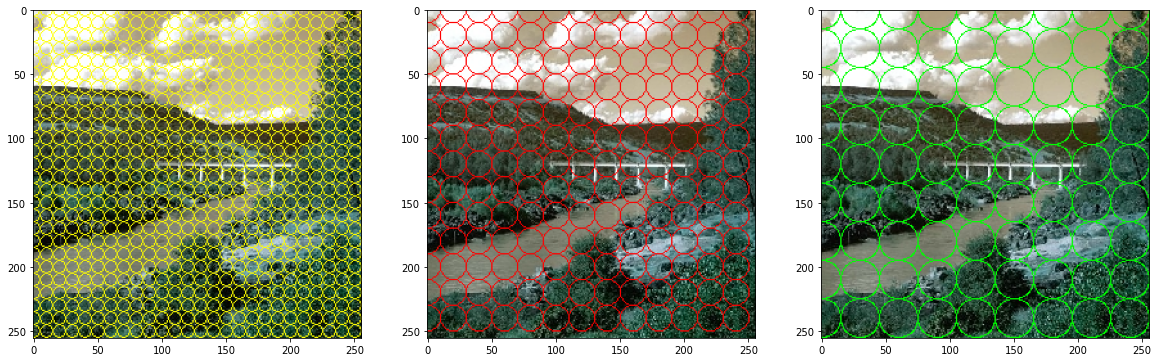

In [ ]:
image = train_images[0]
keypoints_10 = [cv2.KeyPoint(x, y, 10) for y in range(0, image.shape[0], 10) for x in range(0, image.shape[1], 10)]
keypoints_20 = [cv2.KeyPoint(x, y, 20) for y in range(0, image.shape[0], 20) for x in range(0, image.shape[1], 20)]
keypoints_30 = [cv2.KeyPoint(x, y, 30) for y in range(0, image.shape[0], 30) for x in range(0, image.shape[1], 30)]
imWithCircles_10 = drawKeyPts(image.copy(),keypoints_10,(255,255,0),1)
imWithCircles_20 = drawKeyPts(image.copy(),keypoints_20,(255,0,0),1)
imWithCircles_30 = drawKeyPts(image.copy(),keypoints_30,(0,255,0),1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,20*3))
ax1.imshow(imWithCircles_10)
ax2.imshow(imWithCircles_20)
ax3.imshow(imWithCircles_30)

Now, let's run some experiments with different combinations of scales for the keypoints and find the best one. In all cases we will be using `step_size=10`, because in the previous lab we saw that the smaller this size, the better; but using values smaller than $10$ gives us memory errors.

In [10]:
pipe_dense_sift = Pipeline([
    ('visual_words', BagOfVisualWords(codebook_size=256, dense_sift=True)),
    ('classifier', KNeighborsClassifier(n_neighbors=5)) 
], memory='./cache_pipeline')

param_grid = dict(
    visual_words__scales=[[10], [10,20], [10,20,30]]
)

gs = GridSearchCV(pipe_dense_sift, param_grid=param_grid, cv=5, verbose=1, return_train_score=True)
gs.fit(train_images, train_labels)
results_dense_sift = gs.cv_results_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [20]:
table_results(results_dense_sift)

,scales,train_acc,val_acc,mean_fit_time,mean_score_time,mean_time
0,[10],84.330105,71.931401,32.454443,3.506181,35.960624
1,"[10, 20]",85.871916,75.333399,109.983891,12.978687,122.962579
2,"[10, 20, 30]",85.007908,76.183899,280.666585,33.854427,314.521012


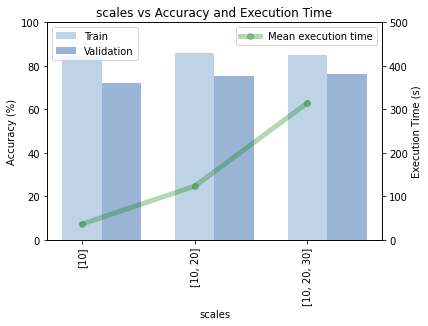

In [24]:
plot_results(results_dense_sift)

As expected, the more scales we use, the better results we obtain (higher validation accuracy); but the execution time seems to increase exponentially. So, we will stay with scales $10$, $20$ and $30$ for the following experiments.

### 2. Normalize descriptors: L2-norm - power norm

In this section we try different normalizations for the descriptors extracted from the images using SIFT. 

In particular, we have used **L2-norm**:
$$
    x_{L2} = \frac{x}{\sqrt{\sum_i^d x_i^2}},
$$ 
and **L1-norm**:
$$
    x_{L1} = \frac{x}{\sum_i^d |x_i|},
$$ 
where $x = [x_1,x_2,...,x_d]$ is a descriptor of dimension $d$.

With the normalization, all the descriptors will have the same relative magnitude. Descriptors with a bigger magnitude are not necessarily related to those with more information, but the algorithm might be biased towards them. Thus, by normalizing descriptors we expect the algorithm to better capture the ones that better discirminate the data.


In [14]:
pipe_norm = Pipeline([
    ('visual_words', BagOfVisualWords(codebook_size=256, dense_sift=True, scales=[10,20,30])),
    ('classifier', KNeighborsClassifier(n_neighbors=5)) 
], memory='./cache_pipeline')

param_grid = dict(
    visual_words__norm=[None,'l1','l2']
)

gs = GridSearchCV(pipe_norm, param_grid=param_grid, cv=5, verbose=1, return_train_score=True)
gs.fit(train_images, train_labels)
results_norm = gs.cv_results_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [17]:
table_results(results_norm)

,norm,train_acc,val_acc,mean_fit_time,mean_score_time,mean_time
0,None,85.007908,76.183899,0.488873,34.131669,34.620542
1,l1,84.715602,74.536938,285.015902,34.938841,319.954743
2,l2,85.127757,75.864891,280.571431,34.610995,315.182426


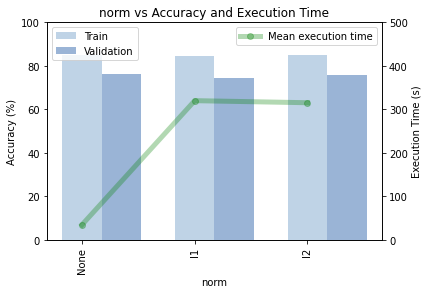

In [25]:
plot_results(results_norm)

From the previous results, we can say that normalizing the descriptors does not have much effect over the accuracy, it even gets a little worst, but the execution time increases a lot. Therefore, we will not normalize the descriptors in the following experiments.

### 3. SVM classifier

Another classifying algorithm that we have seen in class is the Support Vector Machine. Particularly, the primal formulation of the SVM is very fast and easy to understand. We will compare it with the k-NN method below.

In [32]:
from sklearn.svm import LinearSVC, SVC

pipe_svm = Pipeline([
    ('visual_words', BagOfVisualWords(codebook_size=256, dense_sift=True, scales=[10,20,30])),
    ('classifier', KNeighborsClassifier(n_neighbors=5)) 
], memory='./cache_pipeline')

param_grid = dict(
    classifier=[KNeighborsClassifier(n_neighbors=5), LinearSVC(max_iter=10000)]
)

gs = GridSearchCV(pipe_svm, param_grid=param_grid, cv=5, verbose=1, return_train_score=True)
gs.fit(train_images, train_labels)
results_svm = gs.cv_results_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
table_results(results_svm)

,classifier,train_acc,val_acc,mean_fit_time,mean_score_time,mean_time
0,KNeighborsClassifier(),85.007908,76.183899,0.484774,33.454536,33.939310
1,LinearSVC(max_iter=10000),98.564545,73.845448,2.212276,33.216906,35.429182


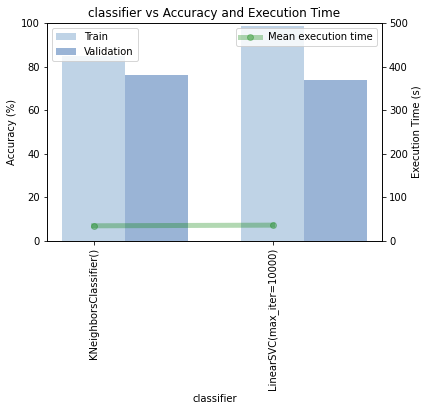

In [34]:
plot_results(results_svm)

For the following experiments, we will use the SVM classifier even if k-NN gives better results. With more time, one could replicate the experiments with k-NN very easily using SVM by choosing the correct kernel and hyperparameters.

### 4. StandardScaler

Scaling the features across all dimensions is specially important for classifiers that depend on computing distance metrics, such as k-NN or SVMs. Below we will try our classifier pipeline with and without scaling the visual words first.

In particular we will try the **standard scaling** (bringing the features to $0$ mean and unit variance):
$$X_{ss} = \frac{X-\mu}{\sigma},$$

where $\sigma$ is the standard deviation of the features and $\mu$ is its mean, and the **min-max scaling**
 (bringing the features in the range between zero and one):
$$X_{mms} = \frac{X - X_{min}}{X_{max} - X_{min}}.$$

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pipe_standard = Pipeline([
    ('visual_words', BagOfVisualWords(codebook_size=256, dense_sift=True, scales=[10,20,30])),
    ('standardize', 'passthrough'),  # keyword to tell sklearn not to do anything
    ('classifier', LinearSVC(max_iter=10000))
], memory='./cache_pipeline')

param_grid = dict(
    standardize=['passthrough', StandardScaler(), MinMaxScaler()]
)

gs = GridSearchCV(pipe_standard, param_grid=param_grid, cv=5, verbose=1, return_train_score=True)
gs.fit(train_images, train_labels)
results_standard = gs.cv_results_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.0.7/libexec/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [36]:
table_results(results_standard)

,standardize,train_acc,val_acc,mean_fit_time,mean_score_time,mean_time
0,passthrough,98.405059,73.632682,2.268794,33.589279,35.858073
1,StandardScaler(),99.707597,74.909701,3.902706,33.487441,37.390148
2,MinMaxScaler(),96.145605,81.660647,0.585799,33.924071,34.509870


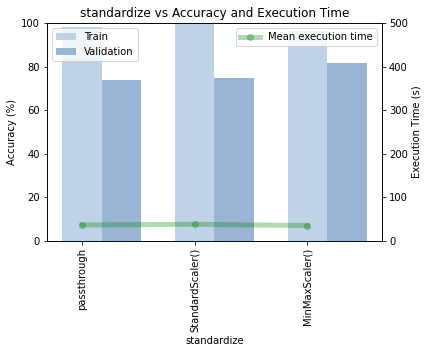

In [37]:
plot_results(results_standard)

As we can see, the option that gives better results (higher validation accuracy) is to scale the features using the min-max scaling, so we will use this option for the following experiments.

### 5. Linear, RBF and histogram intersection kernels

Next, we will try different kernels in the SVM. We will use two widely used kernels, the linear and the rbf, and then one kernel that works with histograms. When comparing the k-NN and the SVM we used a linear SVM, thus the rbf and the histogram intersection kernels are the ones under examination in this experiment.

In [38]:
def histogramIntersection(M, N):
    k_int = np.zeros((M.shape[0], N.shape[0]))
    for i in range(M.shape[0]):
        for j in range(N.shape[0]):
            min_values = [min(M[i,k],N[j,k]) for k in range(M.shape[1])]
            k_int[i,j] = np.sum(min_values, axis=-1)
    return k_int

In [40]:
from sklearn.svm import LinearSVC, SVC

pipe_kernels = Pipeline([
    ('visual_words', BagOfVisualWords(codebook_size=256, dense_sift=True, scales=[10,20,30])),
    ('standardize', MinMaxScaler()),
    ('classifier', SVC()) 
], memory='./cache_pipeline')

param_grid = dict(
    classifier__kernel=['linear','rbf', histogramIntersection],
    classifier__C=[0.5, 1]
)

gs = GridSearchCV(pipe_kernels, param_grid=param_grid, cv=5, verbose=1, return_train_score=True)
gs.fit(train_images, train_labels)
results_kernels = gs.cv_results_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [41]:
table_results(results_kernels)

,C,kernel,train_acc,val_acc,mean_fit_time,mean_score_time,mean_time
0,0.5,linear,91.932450,81.181359,0.567538,35.165533,35.733070
1,0.5,rbf,90.231286,79.533552,0.611635,36.074068,36.685703
2,0.5,<function histogramIntersection at 0x14a0b8670>,99.946835,82.457955,218.764837,88.351863,307.116700
3,1,linear,94.710248,80.117952,0.560126,33.773909,34.334035
4,1,rbf,95.148821,80.916248,0.609452,34.014295,34.623747
5,1,<function histogramIntersection at 0x14a0b8670>,99.946835,82.351713,220.490872,87.477178,307.968049


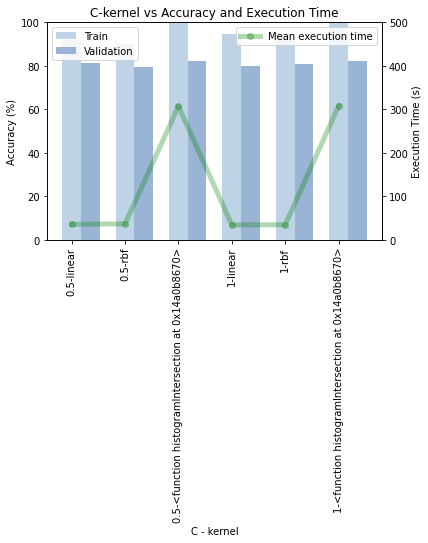

In [42]:
plot_results(results_kernels)

From the table and plot above, we can see that, in general, the kernel that we have defined (`histogramIntersection()`) is the one that gives better results, but it's also the slowest. This makes sense because this kernel is specific for histograms (our case) and it's home-made, so it hasn't been optimise as, probably, the other two kernels are.

On the other hand, the regularization term (`C`) does not have much effect over the results. Nonetheless, with $C=0.5$ the validation accuracy is a little bit higher (and there is no different in execution time), so we will use this configuration for the following experiments. 

### 6. Spatial Pyramids

We can add spatial information to our features by dividing our image into sections and computing visual words for every section. We will finally concatenate all of the visual words into a single feature.
```
┏━━━━━━━━━━━━━━┓     ┏━━━━━━━┯━━━━━━┓
┃              ┃     ┃       ┊      ┃
┃              ┃     ┃  vw_2 ┊ vw_3 ┃
┃     vw_1     ┃  →  ┠┈┈┈┈┈┈┈┼┈┈┈┈┈┈┨  →  ...   vw_final = concatenate(vw_1, vw_2, vw_3, ..., vw_m)
┃              ┃     ┃  vw_4 ┊ vw_5 ┃
┃              ┃     ┃       ┊      ┃
┗━━━━━━━━━━━━━━┛     ┗━━━━━━━┷━━━━━━┛
     depth=0              depth=1   ...    depth=n
```

The visual words will be really sparse: for smaller subsections of the image, there will obviously be less descriptors, but these will also be more similar, and thus it will be more probable they belong to the same cluster in the codebook. Because of this, dimensionality reduction seems like an obvious processing step before classifying the vectors.

Below we will test different values for the depth of our spatial pyramid, and also the effect of reducing the dimensionality for these large features with spatial information.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


pipe_spatial = Pipeline([
    ('visual_words', BagOfVisualWords(codebook_size=256, dense_sift=True, scales=[10,20,30])),
    ('standardize', MinMaxScaler()),
    ('reduce_dim', 'passthrough'),
    ('classifier', SVC(kernel=histogramIntersection, C=0.5))  # use best classifier from previous
], memory='./cache_pipeline')

param_grid = dict(
    visual_words__pyramid_depth=[0,1,2],
    reduce_dim=['passthrough', LinearDiscriminantAnalysis()]
)

gs = GridSearchCV(pipe_spatial, param_grid=param_grid, cv=3, verbose=1, return_train_score=True)
gs.fit(train_images, train_labels)
results_spatial = gs.cv_results_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [ ]:
table_results(results_spatial)

In [ ]:
plot_results(results_spatial)

This experiment has sadly not finished after 5 hours executing; if it does we will share the notebook on Teams.

### 7. ROC curve

Next, we have the ROC curve of the best model that we have achived, with the ROC curves for each class, as well as the mean curves:

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

def plot_ROC(classifier, x, y, figsize=(12,8)):
    y_scores = classifier.predict_proba(x)
    skplt.metrics.plot_roc_curve(y, y_scores, figsize=figsize)
    plt.show()

plot_ROC(gs, test_images, test_labels)

As we can see in the plot, the curves are very close to the ideal point (top-left corner), so we have a good model for the problem at hand.

### 8. (OPTIONAL) Fisher Vectors

Finally, we have implemented the Fisher vectors, and we will compare them with the Bag of Visual Words.<sub><sup>(*)</sup></sub>

<sub><sup>(*) We didn't have time to execute it, so this section is just implemented.</sup></sub>

In [ ]:
class FisherVectors(TransformerMixin, BaseEstimator):
    """Given a set of images, transform them to visual words"""
    def __init__(self, 
                 codebook_size: int, 
                 dense_sift: bool = False, 
                 step_size: int = 10, 
                 scales: list = [10],
                 norm: str = None):
        self.codebook_size = codebook_size
        self.dense_sift = dense_sift
        self.step_size = step_size
        self.scales = scales
        self.norm = norm

    def generate_descriptors(self, images):
        detector = cv2.SIFT_create()
        if self.dense_sift:
            step_size = self.step_size
            scales = self.scales
            keypoints = [sum([[cv2.KeyPoint(x, y, scale) for y in range(0, image.shape[0], step_size) 
                                                         for x in range(0, image.shape[1], step_size)]
                                for scale in scales], [])
                            for image in images]

        descriptors = []
        positions = []
        for idx, image in enumerate(images):
            if self.dense_sift:
                kpt, des = detector.compute(image, keypoints[idx])
            else:
                kpt, des = detector.detectAndCompute(image,None)
            if des is None:
                # if the keypoint detector does not return any keypoint/descriptor
                # we will just use the avg. descriptor of all images until now.
                # it shouldn't have a big effect on classification.
                des = np.vstack(descriptors).mean(axis=0).reshape(1, -1)
            descriptors.append(des)
            positions.append([keypoint.pt for keypoint in kpt])
        descriptors = [np.array(desc) for desc in descriptors]
        
        # Normalize descriptors
        if self.norm is not None:
            descriptors = [normalize(desc, norm=self.norm) for desc in descriptors]
        
        return descriptors, positions

    def fit(self, X, y=None):
        # Generate descriptor features to fit the codebook
        descriptors, _ = self.generate_descriptors(X)
        D = np.vstack(descriptors)

        gmm = GaussianMixture(n_components=self.codebook_size)
        gmm.fit(D)

        #means = np.float32(gmm.getMat("means"))
        #covs = np.float32(gmm.getMatVector("covs"))
        #weights = np.float32(gmm.getMat("weights"))[0]

        #th = 1.0 / self.codebook_size
        #means = np.float32([m for k,m in zip(range(0, len(weights)), means) if weights[k] > th])
        #covs = np.float32([m for k,m in zip(range(0, len(weights)), covs) if weights[k] > th])
        #weights = np.float32([m for k,m in zip(range(0, len(weights)), weights) if weights[k] > th])
        
        self.codebook = gmm
        #self.codebook_means = means
        #self.codebook_covs = covs
        #self.codebook_weights = weights
        return self

    def transform(self, X):

        descriptors = self.generate_descriptors(X)
        words=em.predict(descriptors[0])
        n = len(descriptors)
        k = words.shape[0] #self.codebook_size
        visual_words=np.zeros((n, k), dtype=np.float32)
        for i in range(n):
            words = self.codebook.predict(descriptors[i])
            visual_words[i,:k] = words
        
        return visual_words


def generate_FV_kp(detector: cv2.Feature2D, images: list):
    """
    Given any object with a '.detectAndCompute()' method and an array of images,
    returns a list with shape (num_images, num_keypoints, length_descriptors),
    where `num_keypoints` is different for every image.
    """
    keypoints = [sum([[cv2.KeyPoint(x, y, scale) for y in range(0, image.shape[0], 10) 
                                                 for x in range(0, image.shape[1], 10)]
                        for scale in [10,30]], [])
                    for image in images]
    descriptors = []
    for idx, image in enumerate(images):
        if keypoints:
            kpt, des = detector.compute(image, keypoints[idx])
        else:
            kpt, des = detector.detectAndCompute(image,None)
        if des is None:
            print(f"Did not find keypoints for image {idx}")
            # if the keypoint detector does not return any keypoint/descriptor
            # we will just use the avg. descriptor of all images until now.
            # it shouldn't have a big effect on classification.
            des = np.vstack(descriptors).mean(axis=0).reshape(1, -1)
        descriptors.append(des)

    return descriptors

In [ ]:
pipe_FV = Pipeline([
    ('visual_words', FisherVectors(codebook_size=32, dense_sift=True)),
    ('standardize', MinMaxScaler()),
    ('reduce_dim', LinearDiscriminantAnalysis()),
    ('classifier', SVC(kernel=histogramIntersection, C=0.5)) 
], memory='./cache_pipeline')

param_grid = dict(
    visual_words=[BagOfVisualWords(codebook_size=256, dense_sift=True, scales=[10,20,30], pyramid_depth=2),FisherVectors(codebook_size=32, dense_sift=True)]
)

gs_FV = GridSearchCV(pipe_FV, param_grid=param_grid, cv=3, verbose=1, return_train_score=True)
gs_FV.fit(train_images, train_labels)
results_FV = gs.cv_results_

In [ ]:
table_results(results_FV)

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=83fc0fbb-7cd7-4b09-b8fd-3bab5b3320ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>